In [2]:
#data preparation
from utils import read_data

data = read_data(keep_dates=False)
df_all = data.train_val_df
df_test = data.test_df
df_test = df_test.drop(columns=["time_stamp","station"])
df_all = df_all.drop(columns=["time_stamp","station"])
df_all.columns

Loaded  data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
Loaded  data\PRSA_Data_Changping_20130301-20170228.csv
Loaded  data\PRSA_Data_Dingling_20130301-20170228.csv
Loaded  data\PRSA_Data_Dongsi_20130301-20170228.csv
Loaded  data\PRSA_Data_Guanyuan_20130301-20170228.csv
Loaded  data\PRSA_Data_Gucheng_20130301-20170228.csv
Loaded  data\PRSA_Data_Huairou_20130301-20170228.csv
Loaded  data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
Loaded  data\PRSA_Data_Shunyi_20130301-20170228.csv
Loaded  data\PRSA_Data_Tiantan_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanliu_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanshouxigong_20130301-20170228.csv
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']


Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'WD_E', 'WD_ENE', 'WD_ESE', 'WD_N', 'WD_NE', 'WD_NNE',
       'WD_NNW', 'WD_NW', 'WD_S', 'WD_SE', 'WD_SSE', 'WD_SSW', 'WD_SW', 'WD_W',
       'WD_WNW', 'WD_WSW'],
      dtype='object')

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
import numpy as np

class MLPDataset(tud.Dataset):
    def __init__(self, data):
        self.y = data["PM2.5"].values
        self.x = data[data.columns[1:]].values
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.y[idx], self.x[idx]

In [9]:
model = nn.Sequential(
    nn.Linear(26,10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(3, 1)
)


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-3
batch_size = 300
epochs = 80
test_interval = 5
log_interval = 1000

model = model.to(device).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mlpDataset = MLPDataset(df_all)
train_set, validation_set = torch.utils.data.random_split(mlpDataset, [len(mlpDataset) - 64000, 64000])
train_dataloader = tud.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dataloader = tud.DataLoader(validation_set, batch_size=batch_size)

In [11]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    
    losses = []
    for batch_idx, (y ,x) in enumerate(train_loader):
        y = y.to(device).double()
        x = x.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = F.mse_loss(output, y.view(-1,1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, (batch_idx + 1) * batch_size, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses

In [12]:
def test(model, device, test_loader):
    model.eval()
    losses = []
    accuracy10 = []
    accuracy15 = []
    accuracy20 = []
    for batch_idx, (y ,x) in enumerate(test_loader):
        y = y.to(device).double().view(-1,1)
        x = x.to(device)
        
        with torch.no_grad():
            output = model(x)
            loss = F.mse_loss(output, y)
            losses.append(loss.item())
            diff = output - y
            accuracy10.append(len(diff[abs(diff)<=10]))
            accuracy15.append(len(diff[abs(diff)<=15]))
            accuracy20.append(len(diff[abs(diff)<=20]))
    
    data_size = len(test_loader.dataset)
    print(float(sum(losses))/len(losses), float(sum(accuracy10))/data_size, float(sum(accuracy15))/data_size,
          float(sum(accuracy20))/data_size)
    return float(sum(losses))/len(losses), float(sum(accuracy10))/data_size, \
           float(sum(accuracy15))/data_size, float(sum(accuracy20))/data_size
        
            
    

In [13]:
epoch_losses = []
epoch_test_losses = []
epoch_test_acc10 = []
epoch_test_acc15 = []
epoch_test_acc20 = []
for epoch in range(epochs):
    loss = train(model, device, train_dataloader, optimizer, epoch, log_interval)
    epoch_losses.append(loss)
    test_losses, acc10, acc15, acc20 = test(model, device, validation_dataloader)
    epoch_test_losses.append(test_losses)
    epoch_test_acc10.append(acc10)
    epoch_test_acc15.append(acc15)
    epoch_test_acc20.append(acc20)

4972.073825351215 0.11028125 0.164859375 0.220109375
2349.256988182629 0.2389375 0.35071875 0.454265625
1444.877858249835 0.31378125 0.45284375 0.569625
1190.7462602618716 0.388328125 0.52603125 0.626984375
1075.9490706271208 0.411265625 0.547953125 0.645984375
1000.5911944164513 0.427921875 0.5630625 0.65915625
946.649340805612 0.439671875 0.57221875 0.6676875
903.181473364129 0.447703125 0.578296875 0.672921875
869.9228886817051 0.4489375 0.581734375 0.6766875
840.090586281839 0.452640625 0.585765625 0.679859375
789.5299396503736 0.4593125 0.5968125 0.6905
778.2820506902547 0.462140625 0.59459375 0.68928125
755.4155297548748 0.465609375 0.599546875 0.693625
722.6111721019336 0.470078125 0.6041875 0.69896875
699.3199739747824 0.473890625 0.6105 0.704890625
700.4212712742643 0.47540625 0.607765625 0.702625
685.5217542226434 0.478625 0.6108125 0.70584375
680.3561188315537 0.480203125 0.612109375 0.705359375
669.1086178377029 0.48490625 0.61728125 0.71175
662.8678005766199 0.487671875 0.

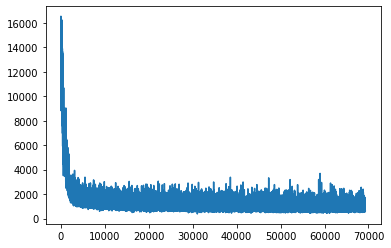

In [14]:
import matplotlib.pyplot as plt
A = np.array(epoch_losses)
plt.plot(A.flatten())

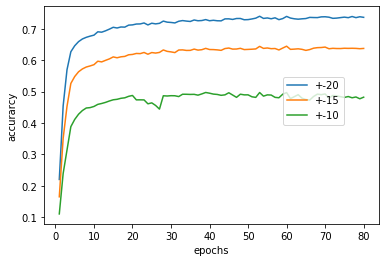

In [15]:
B = np.array(epoch_test_acc20)
C = np.array(epoch_test_acc15)
D = np.array(epoch_test_acc10)
x = range(1,81)
plt.plot(x, B.flatten(), label = "+-20")
plt.plot(x, C.flatten(), label = "+-15")
plt.plot(x, D.flatten(), label = "+-10")
plt.xlabel('epochs')
plt.ylabel('accurarcy')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.show()

In [16]:
test_dataset = MLPDataset(df_test)
test_dataloader = tud.DataLoader(validation_set, batch_size=batch_size)
test_losses, acc10, acc15, acc20 = test(model, device, test_dataloader)

604.3653768556454 0.482203125 0.6375 0.73659375
